# Generative Adversarial Networks (GAN)

## Distribution을 제대로 학습하는가? (확인해보자!)

## MNIST Dataset Generator

# Library

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt

import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import random

# Set torch basic

In [2]:
# CUDA Check
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Set dtype
dtype = torch.double

# Auxilarity functions to print information

In [3]:
# Auxilarity Functions to print information
def show_grid_image(img, title):
    n_img = img.shape[0]
    img = utils.make_grid(img.cpu().detach(), nrow = int(np.ceil(np.sqrt(n_img))))
    
    img = (img + 1) / 2 # We use final filter as Tanh!(보통)
    
    np_img = img.numpy()
    
    plt.figure()
    plt.imshow(np.transpose(np_img, (1, 2, 0)), cmap='gray')
    plt.title(title)
    plt.show()

def show_image(img, title):
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()

# Load the data

In [4]:
mnist_train = datasets.MNIST(
    root='data/',
    train=True,
    transform=transforms.ToTensor(),
    download=True)

mnist_test = datasets.MNIST(
    root='data/',
    train=False,
    transform=transforms.ToTensor(),
    download=True)


print(mnist_train)
print(mnist_test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: ToTensor()


# Set hyperparameters

In [5]:
# Hyperparameter
learning_rate = 2e-4 # 2e-4 success
training_epochs = 200
display_step = 1
batch_size = 100
generator_steps = 1 #DIS~ STEP / step이 높아지면 높아질수록 over fitting 되는 문제가 있음

# Data dimension information
latent_dim = 128 # Generator's input, which means the dimension of latent variable z to generate a image
hidden_dim = 256
image_dim = 784

# Make custom dataset

In [6]:
# Construct custom dataloader for train
class MNIST_Dataset(torch.utils.data.Dataset):
    # Initialize and preprocess the data
    def __init__(self, is_train):
        # MNIST data convert to cuda tensor and change the data type
        if is_train:
            X = mnist_train.data.to(dtype=dtype, device=device)
            y = mnist_train.targets.to(device=device)
        else:
            X = mnist_test.data.to(dtype=dtype, device=device)
            y = mnist_test.targets.to(device=device)
        
        # Normalize
        X = self._normalize(X, 0, 255)
        
        # Reshape the data
        X = self._reshape(X)
        
        # Move to the class object
        self.X = X
        self.y = y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def _normalize(self, data, min_value, max_value): #범위가 확실하기 때문에 따로 해주지 않는 것임
        return (((data - min_value) / (max_value - min_value)) - 0.5 ) * 2
    
    def _reshape(self, data):
        return data.view(-1, image_dim)

# Make batch with dataloader

torch.Size([100, 784])


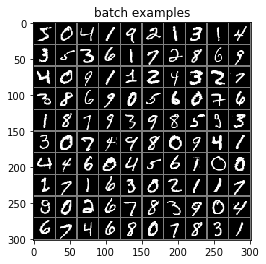

In [7]:
train_data_loader = torch.utils.data.DataLoader(MNIST_Dataset(is_train=True), batch_size, shuffle=False)
test_data_loader = torch.utils.data.DataLoader(MNIST_Dataset(is_train=False), batch_size, shuffle=False)

batch_data_example, batch_label_example = next(iter(train_data_loader))
print(batch_data_example.shape)

# Check the batch images
# show_image(batch_imgs(batch_data_example), "batch examples")
show_grid_image(batch_data_example.view(batch_size, 1, 28, 28), "batch examples")

# Show a image

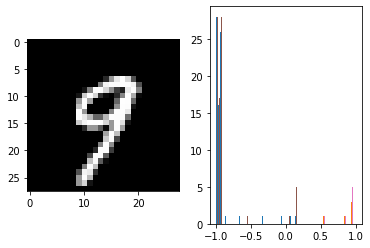

In [8]:
idx = np.random.randint(0, batch_label_example.shape[0])

data = batch_data_example[idx].view(28, 28).cpu().numpy()
label = batch_label_example[idx].cpu().numpy()

_, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(data, cmap="gray")
ax2.hist(data, bins=20, range=[-1, 1])

plt.show()

# Construct models

In [12]:
# Construct a generator
class Generator(torch.nn.Module):
    def __init__(self, latent_dim, hidden_dim, image_dim):
        super(Generator, self).__init__()
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, hidden_dim),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(hidden_dim, image_dim),
            torch.nn.Tanh())
    
    def forward(self, x):
        output = self.linear(x)
        return output

# Construct a discriminator
class Discriminator(torch.nn.Module):
    def __init__(self, image_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(image_dim, hidden_dim),
            torch.nn.LeakyReLU(0.2, inplace=True), #0.2가 각도, 각도가 계속 바뀜
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Linear(hidden_dim, 1),
            torch.nn.Sigmoid())
    
    def forward(self, x):
        output = self.linear(x.view(-1, image_dim))
        return output

# Train configuration for GAN
GAN의 Loss Function은 다음과 같이 나타난다
$$
J_{GAN} = \min_{G}\max_{D}V(D, G) = \mathbb{E}_{x \sim p_{data}(x)}[log D(x)]+\mathbb{E}_{z \sim p_{z}(z)}[log(1-D(G(z)))]
$$
이를 Generator와 Discriminator의 입장에서 각각에 대한 Loss Function으로 나타내면 다음과 같다.
$$
J_{D} = -log D(x) - log (1 - D(G(z))) 
J_{G} = log (1 - D(G(z))) 
$$
-최소화하려면 D(G(z))가 커야함

In [13]:
G = Generator(latent_dim, hidden_dim, image_dim).to(dtype=dtype, device=device)
D = Discriminator(image_dim, hidden_dim).to(dtype=dtype, device=device)

G_optimizer = torch.optim.Adam(G.parameters(), lr = learning_rate)
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate)

# Auxilarity functions for train

In [14]:
# Initialize model parameters
def initialize_parameters(model):
    for p in model.parameters():
        if (p.dim() > 1): #dimension, 콤마 기준으로 나뉨
            torch.nn.init.xavier_normal_(p)
        else:
            torch.nn.init.uniform_(p, 0.1, 0.2)

# Sample z in normal distribution
def sample_z(batch_size, noise_dim):
    return torch.tensor(np.random.normal(0, 1, (batch_size, noise_dim))).to(dtype=dtype, device=device)

# Train the model in a epoch
def train():
    # Set the model to train mode
    G.train()
    D.train()
    
    for data in train_data_loader:
        # Extract images from data
        images, _ = data #? _이건 뭐지
        
        # Random sampling z from gaussian districtuion
        num_data = images.size(0)
        z = sample_z(num_data, latent_dim)
        
        # Train discriminator
        # k-step to train discriminator (but k = 1 in this example)
        # Is large k good or bad and why?
        D_optimizer.zero_grad()
        
        # Loss for true data
        real_loss = -1 * torch.log(D(images)) #D는 image를 판별하는 함수 
        #->D가 높아지면 real이 높아지니까 
        # 0.0
        
        
        # Loss for fake data #가짜도 가짜로 판별
        fake_loss = -1 * torch.log(1. - D(G(z)))
        
        # Loss for Discriminator
        D_loss = torch.mean(real_loss + fake_loss)
        
        D_loss.backward()
        D_optimizer.step()
        
        # Train generator     
        G_optimizer.zero_grad()
            
        # Loss for Generator
        # Quiz ! Why we did not use the log(1 - D(G(z)))
        G_loss = -1 * torch.mean(torch.log(D(G(z))))
            
        G_loss.backward()
        G_optimizer.step()

# Evaluate the training process
def evaluate():
    with torch.no_grad():
        # Set the model to evaluation mode
        G.eval()
        D.eval()
    
        G_loss = 0.0
        D_loss = 0.0
        real_score = 0.0
        fake_score = 0.0
    
        num_total_data = len(mnist_test)
    
        for data in test_data_loader:
            # Extract images from data
            images, _ = data
            
            # Sample z in normal distribution
            z = sample_z(batch_size, latent_dim)
            
            # Calculate loss for generator
            G_loss += (torch.sum(-1 * torch.log(D(G(z))))).item() / num_total_data
            
            # Calculate loss for discriminator
            real_loss = -1 * torch.log(D(images))
            fake_loss = -1 * torch.log(1. - D(G(z)))
            D_loss += (torch.sum(real_loss + fake_loss)).item() / num_total_data
            
            # Caculate discriminator's belief on true data
            real_score += (torch.sum(D(images))).item() / num_total_data
            
            # Caculate discriminator's belief on fake data
            fake_score += (torch.sum(D(G(z)))).item() / num_total_data
            
    return G_loss, D_loss, real_score, fake_score

# Train the model

Training...
Epoch  20
Loss for Generator :  4.118971969818321
Loss for Discriminator :  0.23073046998532826


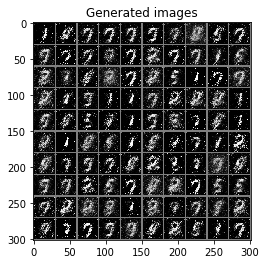

real score :  0.9276556216134586
fake score :  0.05948119494356304

Epoch  40
Loss for Generator :  2.967922607246184
Loss for Discriminator :  0.4635715725296267


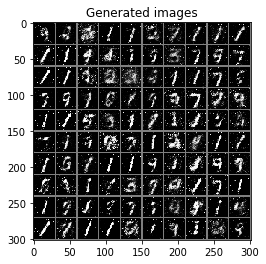

real score :  0.8571240795039624
fake score :  0.1290316618176689

Epoch  60
Loss for Generator :  1.9098978121559087
Loss for Discriminator :  0.8787339807391927


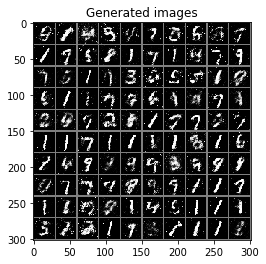

real score :  0.741173583232033
fake score :  0.2600766335933631

Epoch  80
Loss for Generator :  1.8591012622201353
Loss for Discriminator :  0.9311150444272066


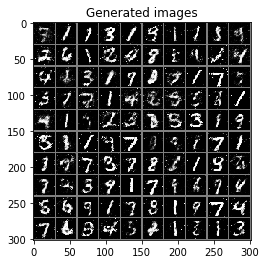

real score :  0.7585852558985945
fake score :  0.2921444078342254

Epoch  100
Loss for Generator :  1.5302599674639885
Loss for Discriminator :  1.0271448212571457


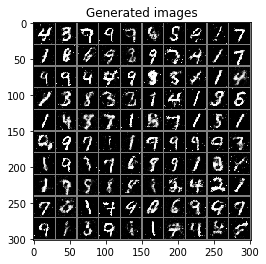

real score :  0.7155366141653634
fake score :  0.32405951131139843

Epoch  120
Loss for Generator :  1.8948165504204124
Loss for Discriminator :  1.097207490505594


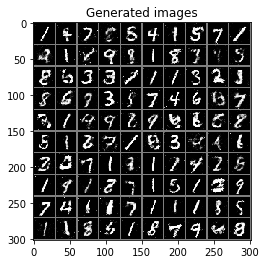

real score :  0.6116173121449943
fake score :  0.2438723044481861

Epoch  140
Loss for Generator :  2.0282498413722787
Loss for Discriminator :  0.9942311498412439


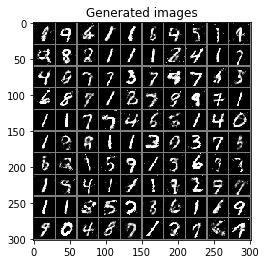

real score :  0.6198283644998479
fake score :  0.21442365033259256

Epoch  160
Loss for Generator :  1.8057859667758387
Loss for Discriminator :  1.1139274976684073


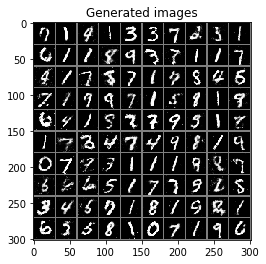

real score :  0.5988464569280918
fake score :  0.25840672769344913



In [ ]:
G_losses = []
D_losses = []
real_scores = []
fake_scores = []

print("Training...")

initialize_parameters(G)
initialize_parameters(D)

for epoch in range(training_epochs):
    # Train the model
    train()
    
    # Evaluate the model
    G_loss, D_loss, real_score, fake_score = evaluate()
    
    G_losses.append(G_loss)
    D_losses.append(D_loss)
    real_scores.append(real_score)
    fake_scores.append(fake_score)
    
    # Print evaluation result
    if (epoch + 1) % 20 == 0:
        print("Epoch ", epoch + 1)
        print("Loss for Generator : ", G_loss)
        print("Loss for Discriminator : ", D_loss)
    
        z = sample_z(batch_size, latent_dim)
        show_grid_image(G(z).view(-1, 1, 28, 28), "Generated images")
    
        print("real score : ", real_score)
        print("fake score : ", fake_score)
        print("")
        
print("Finish Training")    

# Plot train process

In [ ]:
# Plot loss change
plt.figure()
plt.plot(G_losses, label="generator loss")
plt.plot(D_losses, label="discriminator loss")
plt.legend()
plt.show()

# Plot real score and fake score changes
plt.figure()
plt.plot(real_scores, label="real score")
plt.plot(fake_scores, label="fake score")
plt.legend()
plt.show()

# Compare fake image with real image

In [ ]:
# Real image
idx = np.random.randint(0, batch_label_example.shape[0])

real_data = batch_data_example[idx].cpu().view(28, 28).numpy()
real_label = batch_label_example[idx].cpu().numpy()

_, (ax1, ax2) = plt.subplots(1, 2)
plt.title("Real image")

ax1.imshow(real_data, cmap="gray")
ax2.hist(real_data, bins=20, range=[-1, 1])

plt.show()

# Fake image
# Image generation
with torch.no_grad():
    z = sample_z(batch_size, latent_dim)
    
    # Pick a image
    fake_data = G(z)[0].view(28, 28).cpu().numpy()
    
_, (ax1, ax2) = plt.subplots(1, 2)
plt.title("Fake image")

ax1.imshow(fake_data, cmap="gray")
ax2.hist(fake_data, bins=20, range=[-1, 1])

plt.show()

# Make the GAN model to generate gaussian distribution!